In [3]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
from csifile import *

%matplotlib inline

If you need to find some storms:

In [19]:
def find_storms(rate, thresh=2, dry_interval=6, duration=1):
    wet_times = rate[rate>=thresh].index
    time_until_wet = pd.TimedeltaIndex(np.diff(wet_times))

    # there have to be at least dry_interval dry hours between storms and rain_rate has to exceed thresh
    ends = rate[rate>=thresh][0:-1][time_until_wet>=(pd.Timedelta(hours=dry_interval))]
    starts = rate[rate>=thresh][1:][time_until_wet>=(pd.Timedelta(hours=dry_interval))]

    starts = starts.index[0:-1]
    ends = ends.index[1:]
    
    ti = [(starts[n]-pd.Timedelta(minutes=30), ends[n]+pd.Timedelta(minutes=30)) for
           n in range(len(starts)) if ends[n] - starts[n] > pd.Timedelta(hours=duration)]
    
    return ti

In [23]:
def plot_DSD(ds0, start, end, rate):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    fig, ax = plt.subplots(figsize=(12,6))
    ds1 = ds0.sel(time=slice(start, end))
    ds1.plot(cmap=cmap, vmin=0)
    plt.ylim(.25, 5)
    plt.ylabel('Drop diameter (mm)')
    plt.title('{t} Drop Size Distribution (time in UTC)'.format(t=start.date()))
    
    ax2 = ax.twinx()
    ax2.patch.set_alpha(0.0)
    ax2.plot(rate[start:end], 'k')
    ax2.set_ylabel('rain_intensity (mm/hr)')

CPU times: user 1min 4s, sys: 356 ms, total: 1min 4s
Wall time: 1min 7s


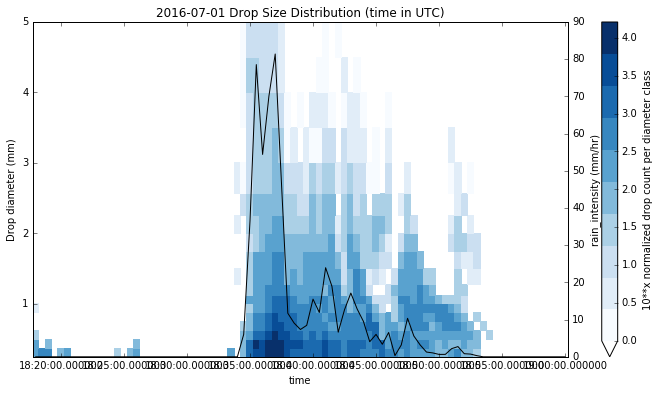

In [24]:
%%time

start = '2016-07-01 18:00'
end = '2016-07-01 19:00'

data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/'

# generate DSDs for any recent storms
cols = [u'mm062', u'mm187', u'mm312', u'mm437', u'mm562', u'mm687', u'mm812',
       u'mm937', u'mm1062', u'mm1187', u'mm1375', u'mm1625', u'mm1875',
       u'mm2125', u'mm2375', u'mm2750', u'mm3250', u'mm3750', u'mm4250',
       u'mm4750', u'mm5500', u'mm6500', u'mm7500', u'mm8500', u'mm9500',
       u'mm11000', u'mm13000', u'mm15000', u'mm17000', u'mm19000', u'mm21500',
       u'mm24']
grid = [(0,0.1245),(0.1245,0.2495),(0.2495,0.3745),(0.3745,0.4995),(0.4995,0.6245),(0.6245,0.7495),
        (0.7495,0.8745),(0.8745,0.9995),(0.9995,1.1245),(1.1245,1.25),(1.25,1.50),(1.50,1.75),
        (1.75,2.00),(2.00,2.25),(2.25,2.50),(2.50,3.00),(3.00,3.50),(3.50,4.00),(4.00,4.50),
        (4.50,5.00),(5.00,6.00),(6.00,7.00),(7.00,8.00),(8.00,9.00),(9.00,10.0),(10.0,12.0),
        (12.0,14.0),(14.0,16.0),(16.0,18.0),(18.0,20.0),(20.0,23.0),(23.0,26.0)]

grid = np.array(grid)
d = dict(zip(cols, grid.mean(axis=1)))

cmap = cm.get_cmap('Blues', 10)
cmap.set_under('None')

rate = xr.open_dataset(data_url+'broadmead_parsivel.nc')['rain_intensity'].to_dataframe()['rain_intensity']

ds = xr.open_dataset(data_url+'broadmead_dropsize.nc')
ds0 = xr.concat([xr.DataArray(ds[n].assign_coords(diameter=d[n]))for n in cols], 'diameter')
ds0.name = '10**x normalized drop count per diameter class'

plot_DSD(ds0, start, end, rate)